# Importing modules and functions

In [6]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import MACCSkeys
import chembl_structure_pipeline
from molvs import standardize_smiles
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold, GridSearchCV
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import joblib
import pickle
import matplotlib.pyplot as plt
from numpy import savetxt
from IPython.display import HTML
from rdkit.Chem import PandasTools

In [7]:
def convert_smi_to_canon_smi(smi):
    
    try:
        canon_smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi),isomericSmiles = False)
    except:
        canon_smi='wrong_smiles'
    return canon_smi

In [8]:
def standart(smi):
    global m
    if smi!='wrong_smiles':
        try:
            smiles=standardize_smiles(smi)
            m = Chem.MolFromSmiles(smi)
        except:
            smi='error kekule'
    else:
        m = 'check the smiles'
    return m

In [9]:
# Set file path
df_ws=pd.read_csv('mouse_intravenous_LD50_WS.csv')
df_ws

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,67-56-1,CO,0.83270,4707.7000
1,19491-72-6,CCCNCC(Br)c1ccccc1,0.89274,30857.5000
2,64790-46-1,CN1C2CCC1CC(OC(=O)C(=O)c1ccccc1)C2,0.90777,33776.0000
3,34758-84-4,COC(CN1CCN(CC(O)C(OC)c2ccccc2)CC1)c1ccccc1,0.93852,44268.0000
4,9005-66-7,CCCCCCCCCCCC(=O)OCCOCC(OCCO)C1OCC(OCCO)C1OCCO,1.01926,49968.0000
...,...,...,...,...
12049,115722-23-1,CCC(C)C(NC(=O)C(N)CC(C)C)C(=O)N1CCCC1C(=O)N1CC...,7.35180,0.0400
12050,4026-95-3,CC12CCC(O)CC1CCC1C2CCC2(C)C(c3ccc(=O)oc3)C(O)C...,7.42650,0.0150
12051,465-19-0,CC12CCC(O)CC1CCC1C2CCC2(C)C(c3ccc(=O)oc3)C(O)C...,7.60480,0.0100
12052,35523-89-8,NC(=O)OCC1N=C(N)N2CCC(O)(O)C23NC(N)=NC13,7.74560,0.0054


 Convert a SMILES string to canonical SMILES

In [10]:
df_ws1 = deepcopy(df_ws)
df_ws1["SMILES"] = df_ws1.apply(lambda x: convert_smi_to_canon_smi(x.SMILES), axis=1)
df_ws1

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,67-56-1,CO,0.83270,4707.7000
1,19491-72-6,CCCNCC(Br)c1ccccc1,0.89274,30857.5000
2,64790-46-1,CN1C2CCC1CC(OC(=O)C(=O)c1ccccc1)C2,0.90777,33776.0000
3,34758-84-4,COC(CN1CCN(CC(O)C(OC)c2ccccc2)CC1)c1ccccc1,0.93852,44268.0000
4,9005-66-7,CCCCCCCCCCCC(=O)OCCOCC(OCCO)C1OCC(OCCO)C1OCCO,1.01926,49968.0000
...,...,...,...,...
12049,115722-23-1,CCC(C)C(NC(=O)C(N)CC(C)C)C(=O)N1CCCC1C(=O)N1CC...,7.35180,0.0400
12050,4026-95-3,CC12CCC(O)CC1CCC1C2CCC2(C)C(c3ccc(=O)oc3)C(O)C...,7.42650,0.0150
12051,465-19-0,CC12CCC(O)CC1CCC1C2CCC2(C)C(c3ccc(=O)oc3)C(O)C...,7.60480,0.0100
12052,35523-89-8,NC(=O)OCC1N=C(N)N2CCC(O)(O)C23NC(N)=NC13,7.74560,0.0054


In [11]:
print('Original data: ', len(df_ws), 'molecules')
print('Failed data: ', len(df_ws1[df_ws1['SMILES']=='wrong_smiles']), 'molecules')

Original data:  12054 molecules
Failed data:  0 molecules


In [12]:
index=df_ws1.index[df_ws1['SMILES']=='wrong_smiles'].tolist()
wrong_smiles=df_ws.iloc[index]
wrong_smiles=wrong_smiles.SMILES
number=[x+1 for x in index]
bad_molecules = pd.DataFrame({'No. failed smiles in original set': number, 'SMILES of wrong structure: ': wrong_smiles}, index=None)
bad_molecules = bad_molecules.set_index('No. failed smiles in original set')
bad_molecules

,SMILES of wrong structure:
No. failed smiles in original set,


##  Standardization  for work set

In [13]:
df_ws1["Molecule"] = df_ws1.apply(lambda x: standart(x.SMILES), axis=1)
moldf_ws=df_ws1[df_ws1['SMILES']!='wrong_smiles']
print('Kept data: ', len(moldf_ws), 'molecules')

Kept data:  12054 molecules


In [14]:
moldf_ws

,CAS_Number,SMILES,pLD50,"LD50,mg/kg",Molecule
0,67-56-1,CO,0.83270,4707.7000,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B6...
1,19491-72-6,CCCNCC(Br)c1ccccc1,0.89274,30857.5000,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B6...
2,64790-46-1,CN1C2CCC1CC(OC(=O)C(=O)c1ccccc1)C2,0.90777,33776.0000,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B6...
3,34758-84-4,COC(CN1CCN(CC(O)C(OC)c2ccccc2)CC1)c1ccccc1,0.93852,44268.0000,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B6...
4,9005-66-7,CCCCCCCCCCCC(=O)OCCOCC(OCCO)C1OCC(OCCO)C1OCCO,1.01926,49968.0000,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B3...
...,...,...,...,...,...
12049,115722-23-1,CCC(C)C(NC(=O)C(N)CC(C)C)C(=O)N1CCCC1C(=O)N1CC...,7.35180,0.0400,<rdkit.Chem.rdchem.Mol object at 0x0000027C736...
12050,4026-95-3,CC12CCC(O)CC1CCC1C2CCC2(C)C(c3ccc(=O)oc3)C(O)C...,7.42650,0.0150,<rdkit.Chem.rdchem.Mol object at 0x0000027C736...
12051,465-19-0,CC12CCC(O)CC1CCC1C2CCC2(C)C(c3ccc(=O)oc3)C(O)C...,7.60480,0.0100,<rdkit.Chem.rdchem.Mol object at 0x0000027C736...
12052,35523-89-8,NC(=O)OCC1N=C(N)N2CCC(O)(O)C23NC(N)=NC13,7.74560,0.0054,<rdkit.Chem.rdchem.Mol object at 0x0000027C736...


In [15]:
y_tr=moldf_ws.pLD50
y_tr

0        0.83270
1        0.89274
2        0.90777
3        0.93852
4        1.01926
          ...   
12049    7.35180
12050    7.42650
12051    7.60480
12052    7.74560
12053    7.89320
Name: pLD50, Length: 12054, dtype: float64

In [16]:
moldf_ws=moldf_ws['Molecule']
moldf_ws

0        <rdkit.Chem.rdchem.Mol object at 0x0000027C6B6...
1        <rdkit.Chem.rdchem.Mol object at 0x0000027C6B6...
2        <rdkit.Chem.rdchem.Mol object at 0x0000027C6B6...
3        <rdkit.Chem.rdchem.Mol object at 0x0000027C6B6...
4        <rdkit.Chem.rdchem.Mol object at 0x0000027C6B3...
                               ...                        
12049    <rdkit.Chem.rdchem.Mol object at 0x0000027C736...
12050    <rdkit.Chem.rdchem.Mol object at 0x0000027C736...
12051    <rdkit.Chem.rdchem.Mol object at 0x0000027C736...
12052    <rdkit.Chem.rdchem.Mol object at 0x0000027C736...
12053    <rdkit.Chem.rdchem.Mol object at 0x0000027C736...
Name: Molecule, Length: 12054, dtype: object

##  Load data and curation test set

In [17]:
df_ts=pd.read_csv('mouse_intravenous_LD50_TS.csv')
df_ts

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,60-35-5,CC(N)=O,0.77135,9994.8000
1,358-21-4,FC(F)(F)C(F)(F)OC(F)(F)C(F)(F)F,0.94248,28995.0000
2,58-86-6,O=CC(O)C(O)C(O)CO,1.12339,11294.2000
3,61-82-5,Nc1nnc[nH]1,1.22573,4997.7000
4,79-16-3,CNC(C)=O,1.26020,4012.7000
...,...,...,...,...
3009,81131-98-8,CC(CCCCCCCC1CC(OS(=O)(=O)O)CCCCCCCCCCCC(OS(=O)...,6.73300,0.1798
3010,2001-95-8,CC1OC(=O)C(C(C)C)NC(=O)C(C(C)C)OC(=O)C(C(C)C)N...,6.79060,0.1799
3011,124-97-0,CCC(C)C(=O)OC1C(O)C2C(CN3CC(C)CCC3C2(C)O)C2CC3...,7.09550,0.0650
3012,13602-52-3,CCC(C)C1C(=O)OCC(NC(=O)c2cnc3ccccc3n2)C(=O)NC(...,7.32040,0.0540


 Convert a SMILES string to canonical SMILES

In [18]:
df_ts1 = deepcopy(df_ts)
df_ts1["SMILES"] = df_ts1.apply(lambda x: convert_smi_to_canon_smi(x.SMILES), axis=1)
df_ts1

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,60-35-5,CC(N)=O,0.77135,9994.8000
1,358-21-4,FC(F)(F)C(F)(F)OC(F)(F)C(F)(F)F,0.94248,28995.0000
2,58-86-6,O=CC(O)C(O)C(O)CO,1.12339,11294.2000
3,61-82-5,Nc1nnc[nH]1,1.22573,4997.7000
4,79-16-3,CNC(C)=O,1.26020,4012.7000
...,...,...,...,...
3009,81131-98-8,CC(CCCCCCCC1CC(OS(=O)(=O)O)CCCCCCCCCCCC(OS(=O)...,6.73300,0.1798
3010,2001-95-8,CC1OC(=O)C(C(C)C)NC(=O)C(C(C)C)OC(=O)C(C(C)C)N...,6.79060,0.1799
3011,124-97-0,CCC(C)C(=O)OC1C(O)C2C(CN3CC(C)CCC3C2(C)O)C2CC3...,7.09550,0.0650
3012,13602-52-3,CCC(C)C1C(=O)OCC(NC(=O)c2cnc3ccccc3n2)C(=O)NC(...,7.32040,0.0540


In [19]:
print('Original data: ', len(df_ts), 'molecules')
print('Failed data: ', len(df_ts1[df_ts1['SMILES']=='wrong_smiles']), 'molecules')

Original data:  3014 molecules
Failed data:  0 molecules


In [20]:
index=df_ts1.index[df_ts1['SMILES']=='wrong_smiles'].tolist()
wrong_smiles=df_ts.iloc[index]
wrong_smiles=wrong_smiles.SMILES
number=[x+1 for x in index]
bad_molecules = pd.DataFrame({'No. failed smiles in original set': number, 'SMILES of wrong structure: ': wrong_smiles}, index=None)
bad_molecules = bad_molecules.set_index('No. failed smiles in original set')
bad_molecules

,SMILES of wrong structure:
No. failed smiles in original set,


##  Standardization  for test set

In [21]:
df_ts1["Molecule"] = df_ts1.apply(lambda x: standart(x.SMILES), axis=1)
moldf_ts=df_ts1[df_ts1['SMILES']!='wrong_smiles']
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  3014 molecules


In [22]:
df_ts1

,CAS_Number,SMILES,pLD50,"LD50,mg/kg",Molecule
0,60-35-5,CC(N)=O,0.77135,9994.8000,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B7...
1,358-21-4,FC(F)(F)C(F)(F)OC(F)(F)C(F)(F)F,0.94248,28995.0000,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B7...
2,58-86-6,O=CC(O)C(O)C(O)CO,1.12339,11294.2000,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B7...
3,61-82-5,Nc1nnc[nH]1,1.22573,4997.7000,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B7...
4,79-16-3,CNC(C)=O,1.26020,4012.7000,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B7...
...,...,...,...,...,...
3009,81131-98-8,CC(CCCCCCCC1CC(OS(=O)(=O)O)CCCCCCCCCCCC(OS(=O)...,6.73300,0.1798,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B4...
3010,2001-95-8,CC1OC(=O)C(C(C)C)NC(=O)C(C(C)C)OC(=O)C(C(C)C)N...,6.79060,0.1799,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B4...
3011,124-97-0,CCC(C)C(=O)OC1C(O)C2C(CN3CC(C)CCC3C2(C)O)C2CC3...,7.09550,0.0650,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B4...
3012,13602-52-3,CCC(C)C1C(=O)OCC(NC(=O)c2cnc3ccccc3n2)C(=O)NC(...,7.32040,0.0540,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B4...


In [23]:
y_ts=moldf_ts.pLD50

In [24]:
moldf_ts

,CAS_Number,SMILES,pLD50,"LD50,mg/kg",Molecule
0,60-35-5,CC(N)=O,0.77135,9994.8000,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B7...
1,358-21-4,FC(F)(F)C(F)(F)OC(F)(F)C(F)(F)F,0.94248,28995.0000,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B7...
2,58-86-6,O=CC(O)C(O)C(O)CO,1.12339,11294.2000,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B7...
3,61-82-5,Nc1nnc[nH]1,1.22573,4997.7000,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B7...
4,79-16-3,CNC(C)=O,1.26020,4012.7000,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B7...
...,...,...,...,...,...
3009,81131-98-8,CC(CCCCCCCC1CC(OS(=O)(=O)O)CCCCCCCCCCCC(OS(=O)...,6.73300,0.1798,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B4...
3010,2001-95-8,CC1OC(=O)C(C(C)C)NC(=O)C(C(C)C)OC(=O)C(C(C)C)N...,6.79060,0.1799,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B4...
3011,124-97-0,CCC(C)C(=O)OC1C(O)C2C(CN3CC(C)CCC3C2(C)O)C2CC3...,7.09550,0.0650,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B4...
3012,13602-52-3,CCC(C)C1C(=O)OCC(NC(=O)c2cnc3ccccc3n2)C(=O)NC(...,7.32040,0.0540,<rdkit.Chem.rdchem.Mol object at 0x0000027C6B4...


## Calculation MorganFingerprint for work set

In [25]:
moldf_ws

0        <rdkit.Chem.rdchem.Mol object at 0x0000027C6B6...
1        <rdkit.Chem.rdchem.Mol object at 0x0000027C6B6...
2        <rdkit.Chem.rdchem.Mol object at 0x0000027C6B6...
3        <rdkit.Chem.rdchem.Mol object at 0x0000027C6B6...
4        <rdkit.Chem.rdchem.Mol object at 0x0000027C6B3...
                               ...                        
12049    <rdkit.Chem.rdchem.Mol object at 0x0000027C736...
12050    <rdkit.Chem.rdchem.Mol object at 0x0000027C736...
12051    <rdkit.Chem.rdchem.Mol object at 0x0000027C736...
12052    <rdkit.Chem.rdchem.Mol object at 0x0000027C736...
12053    <rdkit.Chem.rdchem.Mol object at 0x0000027C736...
Name: Molecule, Length: 12054, dtype: object

In [26]:
def calcfp(mol):
    fp = MACCSkeys.GenMACCSKeys(mol)
    fp = pd.Series(np.asarray(fp))
    fp = fp.add_prefix('MACCS_')
    return fp

In [27]:
desc_ws = moldf_ws.apply(calcfp)

In [28]:
desc_ws

,MACCS_0,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,MACCS_6,MACCS_7,MACCS_8,MACCS_9,...,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12049,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
12050,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
12051,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
12052,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,0,1,1,1,0


## Calculation MorganFingerprint for test set

In [29]:
desc_ts = moldf_ts.Molecule.apply(calcfp)
desc_ts

,MACCS_0,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,MACCS_6,MACCS_7,MACCS_8,MACCS_9,...,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3009,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,1,1,0
3010,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,0,1,1,0
3011,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,1,1,0
3012,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


# BASELINE

 ## GradientBoostingRegressor model building and validation

In [27]:
x_tr = np.array(desc_ws, dtype=np.float32)
y_tr = np.array(y_tr, dtype=np.float32)

In [58]:
seed = 42

In [59]:
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [145]:
param_grid = {'learning_rate': [0.01, 0.04],
                  'subsample'    : [0.9, 0.5],
                  'n_estimators' : [100,1000, 2000],
                  'max_depth'    : [4, 10]
                 }

In [146]:
m = GridSearchCV(GradientBoostingRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [147]:
%%time
m.fit(desc_ws, y_tr)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: total: 1min 16s
Wall time: 23min 14s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.04], 'max_depth': [4, 10],
                         'n_estimators': [100, 1000, 2000],
                         'subsample': [0.9, 0.5]},
             verbose=1)

In [148]:
best_GBR = m.best_estimator_

In [149]:
m.best_params_

{'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 1000,
 'subsample': 0.5}

In [151]:
y_pred_CV_GBR = cross_val_predict(best_GBR, desc_ws, y_tr, cv=cv, n_jobs=-1)

In [152]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.54

In [153]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.46

# save the model to disk

In [154]:
pickle.dump(best_GBR, open('Models/MACCS/GBR_MACCS_baseline.pkl', 'wb'))

# load the model from disk

In [38]:
best_SVM = pickle.load(open('Models/MACCS/GBR_MACCS_baseline.pkl', 'rb'))

# SVM BASELINE

In [55]:
SVM_MACCS_baseline = pickle.load(open('Models/MACCS/LD50_mouse_introvenus_SVM_MACCS.pkl', 'rb'))

In [161]:
y_pred_CV_svm = cross_val_predict(SVM_MACCS_baseline, desc_ws, y_tr, cv=cv)

In [162]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.53

In [164]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.46

In [165]:
x_ts=desc_ts

In [166]:
y_ts = np.array(y_ts, dtype=np.float32)

In [167]:
y_pred_SVM = SVM_MACCS_baseline.predict(x_ts)

C:\ProgramData\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


In [168]:
Q2_TS = round(r2_score(y_ts, y_pred_SVM), 2)
Q2_TS

0.55

In [169]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_SVM)), 2)
RMSE_TS

0.46

# VarianceThreshold

In [56]:
estimator=SVM_MACCS_baseline

In [ ]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
def variance_threshold_selector(data, threshold=0.05):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [172]:
x_tr_const_and_nearcont=variance_threshold_selector(desc_ws, 0.05)
x_tr_const_and_nearcont

,MACCS_19,MACCS_24,MACCS_36,MACCS_37,MACCS_38,MACCS_42,MACCS_43,MACCS_47,MACCS_50,MACCS_52,...,MACCS_156,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,1,1,0,1
2,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12049,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,1
12050,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,1,1,1
12051,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,1,1,1
12052,0,0,0,0,1,0,1,0,0,0,...,1,1,1,1,0,1,0,1,1,1


In [174]:
estimator.fit(x_tr_const_and_nearcont, y_tr)

SVR(C=1, epsilon=0.2, gamma=0.1)

In [175]:
y_pred_CV_SVM = cross_val_predict(estimator, x_tr_const_and_nearcont, y_tr, cv=cv, n_jobs=-1)

In [176]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_SVM), 2)
Q2_CV

0.53

In [177]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_SVM)), 2)
RMSE_CV

0.47

# Removing highly correlated features

In [178]:
cor_df = x_tr_const_and_nearcont.corr().abs()
cor_df

,MACCS_19,MACCS_24,MACCS_36,MACCS_37,MACCS_38,MACCS_42,MACCS_43,MACCS_47,MACCS_50,MACCS_52,...,MACCS_156,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165
MACCS_19,1.000000,0.004611,0.177000,0.033963,0.001407,0.031114,0.029967,0.055096,0.038012,0.015652,...,0.012956,0.003418,0.058185,0.011301,0.039029,0.038821,0.011648,0.037226,0.036593,0.067016
MACCS_24,0.004611,1.000000,0.022899,0.030350,0.004935,0.009116,0.012221,0.027469,0.076333,0.024466,...,0.126943,0.004743,0.053965,0.143132,0.082541,0.091371,0.063140,0.013914,0.106132,0.019560
MACCS_36,0.177000,0.022899,1.000000,0.042927,0.001642,0.002007,0.038312,0.375734,0.047121,0.017023,...,0.022655,0.083693,0.042900,0.087837,0.001431,0.053098,0.067804,0.037230,0.068424,0.079079
MACCS_37,0.033963,0.030350,0.042927,1.000000,0.238735,0.021741,0.289041,0.005023,0.069614,0.076294,...,0.174991,0.082027,0.118954,0.029316,0.005549,0.105318,0.051585,0.054181,0.122332,0.052736
MACCS_38,0.001407,0.004935,0.001642,0.238735,1.000000,0.011147,0.120676,0.084506,0.080354,0.060669,...,0.189890,0.121433,0.078429,0.051666,0.000708,0.114285,0.128991,0.075482,0.048363,0.078423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MACCS_161,0.038821,0.091371,0.053098,0.105318,0.114285,0.111355,0.091127,0.105190,0.075005,0.092363,...,0.601848,0.111020,0.811238,0.076295,0.068966,1.000000,0.280871,0.275511,0.077692,0.276351
MACCS_162,0.011648,0.063140,0.067804,0.051585,0.128991,0.015707,0.009969,0.006521,0.095168,0.036340,...,0.204414,0.000820,0.226124,0.029291,0.020574,0.280871,1.000000,0.600134,0.021682,0.549047
MACCS_163,0.037226,0.013914,0.037230,0.054181,0.075482,0.042454,0.019510,0.037038,0.037199,0.015069,...,0.202636,0.057340,0.262637,0.040340,0.039248,0.275511,0.600134,1.000000,0.040375,0.736066
MACCS_164,0.036593,0.106132,0.068424,0.122332,0.048363,0.009619,0.049102,0.114686,0.008985,0.017528,...,0.009766,0.588288,0.009272,0.571565,0.121006,0.077692,0.021682,0.040375,1.000000,0.056161


In [179]:
cor_df = x_tr_const_and_nearcont.corr().abs()
cor_df

,MACCS_19,MACCS_24,MACCS_36,MACCS_37,MACCS_38,MACCS_42,MACCS_43,MACCS_47,MACCS_50,MACCS_52,...,MACCS_156,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165
MACCS_19,1.000000,0.004611,0.177000,0.033963,0.001407,0.031114,0.029967,0.055096,0.038012,0.015652,...,0.012956,0.003418,0.058185,0.011301,0.039029,0.038821,0.011648,0.037226,0.036593,0.067016
MACCS_24,0.004611,1.000000,0.022899,0.030350,0.004935,0.009116,0.012221,0.027469,0.076333,0.024466,...,0.126943,0.004743,0.053965,0.143132,0.082541,0.091371,0.063140,0.013914,0.106132,0.019560
MACCS_36,0.177000,0.022899,1.000000,0.042927,0.001642,0.002007,0.038312,0.375734,0.047121,0.017023,...,0.022655,0.083693,0.042900,0.087837,0.001431,0.053098,0.067804,0.037230,0.068424,0.079079
MACCS_37,0.033963,0.030350,0.042927,1.000000,0.238735,0.021741,0.289041,0.005023,0.069614,0.076294,...,0.174991,0.082027,0.118954,0.029316,0.005549,0.105318,0.051585,0.054181,0.122332,0.052736
MACCS_38,0.001407,0.004935,0.001642,0.238735,1.000000,0.011147,0.120676,0.084506,0.080354,0.060669,...,0.189890,0.121433,0.078429,0.051666,0.000708,0.114285,0.128991,0.075482,0.048363,0.078423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MACCS_161,0.038821,0.091371,0.053098,0.105318,0.114285,0.111355,0.091127,0.105190,0.075005,0.092363,...,0.601848,0.111020,0.811238,0.076295,0.068966,1.000000,0.280871,0.275511,0.077692,0.276351
MACCS_162,0.011648,0.063140,0.067804,0.051585,0.128991,0.015707,0.009969,0.006521,0.095168,0.036340,...,0.204414,0.000820,0.226124,0.029291,0.020574,0.280871,1.000000,0.600134,0.021682,0.549047
MACCS_163,0.037226,0.013914,0.037230,0.054181,0.075482,0.042454,0.019510,0.037038,0.037199,0.015069,...,0.202636,0.057340,0.262637,0.040340,0.039248,0.275511,0.600134,1.000000,0.040375,0.736066
MACCS_164,0.036593,0.106132,0.068424,0.122332,0.048363,0.009619,0.049102,0.114686,0.008985,0.017528,...,0.009766,0.588288,0.009272,0.571565,0.121006,0.077692,0.021682,0.040375,1.000000,0.056161


In [180]:
mask=np.triu(np.ones_like(cor_df, dtype=bool))

In [181]:
tri_df=cor_df.mask(mask)
tri_df

,MACCS_19,MACCS_24,MACCS_36,MACCS_37,MACCS_38,MACCS_42,MACCS_43,MACCS_47,MACCS_50,MACCS_52,...,MACCS_156,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165
MACCS_19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACCS_24,0.004611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACCS_36,0.177000,0.022899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACCS_37,0.033963,0.030350,0.042927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACCS_38,0.001407,0.004935,0.001642,0.238735,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MACCS_161,0.038821,0.091371,0.053098,0.105318,0.114285,0.111355,0.091127,0.105190,0.075005,0.092363,...,0.601848,0.111020,0.811238,0.076295,0.068966,NaN,NaN,NaN,NaN,NaN
MACCS_162,0.011648,0.063140,0.067804,0.051585,0.128991,0.015707,0.009969,0.006521,0.095168,0.036340,...,0.204414,0.000820,0.226124,0.029291,0.020574,0.280871,NaN,NaN,NaN,NaN
MACCS_163,0.037226,0.013914,0.037230,0.054181,0.075482,0.042454,0.019510,0.037038,0.037199,0.015069,...,0.202636,0.057340,0.262637,0.040340,0.039248,0.275511,0.600134,NaN,NaN,NaN
MACCS_164,0.036593,0.106132,0.068424,0.122332,0.048363,0.009619,0.049102,0.114686,0.008985,0.017528,...,0.009766,0.588288,0.009272,0.571565,0.121006,0.077692,0.021682,0.040375,NaN,NaN


In [182]:
to_drop=[c for c in tri_df.columns if any(tri_df[c]>0.95) ]
to_drop

['MACCS_110', 'MACCS_118', 'MACCS_127']

In [183]:
reduced_df_cor=x_tr_const_and_nearcont.drop(to_drop, axis=1)

In [184]:
reduced_df_cor

,MACCS_19,MACCS_24,MACCS_36,MACCS_37,MACCS_38,MACCS_42,MACCS_43,MACCS_47,MACCS_50,MACCS_52,...,MACCS_156,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,1,1,0,1
2,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12049,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,1
12050,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,1,1,1
12051,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,1,1,1
12052,0,0,0,0,1,0,1,0,0,0,...,1,1,1,1,0,1,0,1,1,1


In [185]:
estimator.fit(reduced_df_cor, y_tr)

SVR(C=1, epsilon=0.2, gamma=0.1)

In [186]:
y_pred_CV_SVM = cross_val_predict(estimator, reduced_df_cor, y_tr, cv=cv, n_jobs=-1)

In [187]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_SVM), 2)
Q2_CV

0.53

In [188]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_SVM)), 2)
RMSE_CV

0.47

In [189]:
feature_name_reduced_df_cor = reduced_df_cor.columns.tolist()
len(feature_name_reduced_df_cor)

111

# Prediction for test set's molecules

In [190]:
x_ts=desc_ts[feature_name_reduced_df_cor]

In [191]:
y_ts = np.array(y_ts, dtype=np.float32)

In [192]:
y_pred_SVM = estimator.predict(x_ts)

In [193]:
Q2_TS = round(r2_score(y_ts, y_pred_SVM), 2)
Q2_TS

0.54

In [194]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_SVM)), 2)
RMSE_TS

0.46

# Permutation-importance

In [195]:
reduced_df_cor_array = reduced_df_cor.to_numpy()

In [196]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel

In [197]:
sel = SelectFromModel(PermutationImportance(estimator, cv=cv),threshold=0.005,).fit(reduced_df_cor_array, y_tr)

In [198]:
X_permut_import = sel.transform(reduced_df_cor)
X_permut_import.shape

C:\ProgramData\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(12054, 60)

In [199]:
feature_idx = sel.get_support()
feature_name = reduced_df_cor.columns[feature_idx]
feature_name 

Index(['MACCS_47', 'MACCS_57', 'MACCS_66', 'MACCS_79', 'MACCS_80', 'MACCS_86',
       'MACCS_89', 'MACCS_90', 'MACCS_91', 'MACCS_92', 'MACCS_93', 'MACCS_95',
       'MACCS_96', 'MACCS_98', 'MACCS_99', 'MACCS_100', 'MACCS_101',
       'MACCS_104', 'MACCS_105', 'MACCS_106', 'MACCS_107', 'MACCS_108',
       'MACCS_109', 'MACCS_112', 'MACCS_113', 'MACCS_115', 'MACCS_116',
       'MACCS_117', 'MACCS_120', 'MACCS_121', 'MACCS_123', 'MACCS_125',
       'MACCS_126', 'MACCS_128', 'MACCS_129', 'MACCS_131', 'MACCS_132',
       'MACCS_133', 'MACCS_134', 'MACCS_136', 'MACCS_137', 'MACCS_138',
       'MACCS_139', 'MACCS_140', 'MACCS_141', 'MACCS_142', 'MACCS_143',
       'MACCS_144', 'MACCS_145', 'MACCS_146', 'MACCS_149', 'MACCS_150',
       'MACCS_151', 'MACCS_152', 'MACCS_154', 'MACCS_155', 'MACCS_156',
       'MACCS_161', 'MACCS_162', 'MACCS_163'],
      dtype='object')

In [200]:
estimator.fit(X_permut_import, y_tr)

SVR(C=1, epsilon=0.2, gamma=0.1)

In [201]:
y_pred_CV_SVM = cross_val_predict(estimator, X_permut_import, y_tr, cv=cv, n_jobs=-1)

In [202]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_SVM), 2)
Q2_CV

0.5

In [203]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_SVM)), 2)
RMSE_CV

0.48

 # Recursive feature elimination

In [204]:
from sklearn.feature_selection import RFECV

SVR(C=1, epsilon=0.2, gamma=0.1)

In [206]:
rfecv = RFECV(estimator=GradientBoostingRegressor(), cv=cv, scoring='r2')
rfecv.fit(reduced_df_cor, y_tr)

RFECV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
      estimator=GradientBoostingRegressor(), scoring='r2')

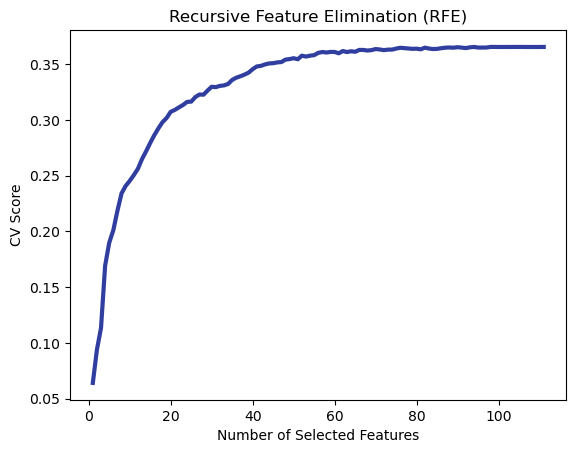

The optimal number of features: 98


In [207]:
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"], color='#303F9F', linewidth=3)
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Score")
plt.title("Recursive Feature Elimination (RFE)")
plt.show()
print("The optimal number of features: {}".format(rfecv.n_features_))

Make a new DataFrame called "X_rfe" that contains selected features.

In [208]:
reduced_df_cor = np.array(reduced_df_cor, dtype=np.float32)

In [209]:
X_rfe = reduced_df_cor[:, rfecv.support_]

In [210]:
X_rfe.shape

(12054, 98)

In [211]:
estimator.fit(X_rfe, y_tr)

SVR(C=1, epsilon=0.2, gamma=0.1)

In [60]:
y_pred_CV_GBR = cross_val_predict(estimator, X_rfe, y_tr, cv=cv, n_jobs=-1)

In [61]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.53

In [62]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.47

In [215]:
reduced_df_cor=x_tr_const_and_nearcont.drop(to_drop, axis=1)

In [216]:
feature_idx = rfecv.get_support()
feature_name_rfecv = reduced_df_cor.columns[feature_idx]
feature_name_rfecv

Index(['MACCS_19', 'MACCS_24', 'MACCS_36', 'MACCS_37', 'MACCS_38', 'MACCS_42',
       'MACCS_43', 'MACCS_47', 'MACCS_50', 'MACCS_52', 'MACCS_53', 'MACCS_54',
       'MACCS_57', 'MACCS_59', 'MACCS_62', 'MACCS_64', 'MACCS_65', 'MACCS_66',
       'MACCS_69', 'MACCS_72', 'MACCS_73', 'MACCS_74', 'MACCS_76', 'MACCS_78',
       'MACCS_79', 'MACCS_80', 'MACCS_81', 'MACCS_82', 'MACCS_83', 'MACCS_84',
       'MACCS_86', 'MACCS_87', 'MACCS_88', 'MACCS_89', 'MACCS_90', 'MACCS_91',
       'MACCS_92', 'MACCS_93', 'MACCS_94', 'MACCS_95', 'MACCS_96', 'MACCS_98',
       'MACCS_99', 'MACCS_100', 'MACCS_101', 'MACCS_103', 'MACCS_104',
       'MACCS_105', 'MACCS_106', 'MACCS_107', 'MACCS_108', 'MACCS_109',
       'MACCS_111', 'MACCS_112', 'MACCS_113', 'MACCS_114', 'MACCS_115',
       'MACCS_116', 'MACCS_117', 'MACCS_119', 'MACCS_120', 'MACCS_121',
       'MACCS_123', 'MACCS_124', 'MACCS_125', 'MACCS_126', 'MACCS_128',
       'MACCS_129', 'MACCS_130', 'MACCS_131', 'MACCS_132', 'MACCS_133',
       'MACCS_13

In [220]:
from pathlib import Path

In [221]:
urls=list(feature_name_rfecv)

In [222]:
path = Path('feature_name_rfecv_MCCS.txt')

In [223]:
path.write_text('\n'.join(urls))

936

In [47]:
from pathlib import Path

In [48]:
path = Path('feature_name_rfecv_MCCS.txt')
feature_name_rfecv_MACCS = path.read_text().splitlines()

In [54]:
X_rfe=desc_ws[feature_name_rfecv_MACCS]
X_rfe

,MACCS_19,MACCS_24,MACCS_36,MACCS_37,MACCS_38,MACCS_42,MACCS_43,MACCS_47,MACCS_50,MACCS_52,...,MACCS_153,MACCS_155,MACCS_156,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,1,1,1,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12049,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,1
12050,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,1
12051,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,1
12052,0,0,0,0,1,0,1,0,0,0,...,1,1,1,1,1,1,0,1,0,1


# Prediction for test set's molecules

In [43]:
x_ts=desc_ts[feature_name_rfecv_MACCS]

In [50]:
x_ts

,MACCS_19,MACCS_24,MACCS_36,MACCS_37,MACCS_38,MACCS_42,MACCS_43,MACCS_47,MACCS_50,MACCS_52,...,MACCS_153,MACCS_155,MACCS_156,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,1,...,0,0,1,0,1,0,0,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3009,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,0,0
3010,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,0,0
3011,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,1
3012,0,0,1,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [51]:
y_ts = np.array(y_ts, dtype=np.float32)

In [66]:
estimator=best_SVM

In [67]:
y_pred_GBR = estimator.predict(x_ts)

C:\ProgramData\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


In [68]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.54

In [69]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.46

# save the model to disk

In [230]:
pickle.dump(estimator, open('Models/MACCS/HDAC3_SVM_MACCS_final_FE.pkl', 'wb'))

# load the model from disk

In [65]:
best_SVM= pickle.load(open('Models/MACCS/LD50_mouse_introvenus_MACCS_final_FE.pkl', 'rb'))

# 10. Y-randomization RF model

In [233]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_SVM, X_rfe, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 13.7min finished


True score =  0.53 
Y-randomization =  -0.1 
p-value =  0.0196


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [70]:
neighbors_k= pairwise_distances(X_rfe, n_jobs=-1)
neighbors_k.sort(0)

In [71]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,12044,12045,12046,12047,12048,12049,12050,12051,12052,12053
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.732051,2.000000,1.414214,3.162278,3.000000,2.236068,2.236068,2.449490,2.000000,2.645751,...,1.000000,1.000000,3.605551,1.732051,1.000000,2.000000,1.000000,0.000000,3.464102,3.605551
2,1.732051,2.000000,1.732051,3.162278,3.316625,2.645751,2.449490,2.449490,2.645751,2.645751,...,1.000000,3.316625,3.872983,1.732051,1.414214,2.000000,1.414214,1.000000,3.464102,3.741657
3,2.000000,2.449490,1.732051,3.162278,3.464102,2.645751,2.449490,2.449490,2.645751,3.316625,...,1.414214,3.464102,4.000000,2.236068,1.414214,3.000000,1.732051,1.414214,3.464102,3.872983
4,2.000000,2.449490,2.000000,3.162278,3.605551,2.645751,2.449490,2.645751,2.828427,3.464102,...,1.732051,3.741657,4.000000,2.236068,2.000000,3.464102,1.732051,1.414214,3.464102,3.872983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12049,8.185353,8.000000,7.280110,7.483315,8.062258,7.874008,8.000000,8.000000,7.416198,7.348469,...,7.810250,7.745967,8.000000,8.000000,7.745967,7.549834,7.745967,7.810250,7.681146,7.937254
12050,8.185353,8.000000,7.280110,7.483315,8.062258,7.937254,8.062258,8.000000,7.549834,7.348469,...,7.874008,7.745967,8.062258,8.000000,7.745967,7.681146,7.745967,7.810250,7.681146,7.937254
12051,8.185353,8.062258,7.416198,7.549834,8.124038,7.937254,8.124038,8.062258,7.549834,7.348469,...,7.874008,7.745967,8.062258,8.062258,7.810250,7.681146,7.810250,7.810250,7.681146,8.000000
12052,8.185353,8.062258,7.416198,7.549834,8.124038,8.000000,8.185353,8.062258,7.549834,7.416198,...,7.937254,7.745967,8.062258,8.062258,7.810250,7.681146,7.874008,7.874008,7.681146,8.000000


In [72]:
similarity= neighbors_k

In [73]:
Dmean=np.mean(similarity[1,:])

In [74]:
round(Dmean, 2)

1.75

In [75]:
std=np.std(similarity[1,:])

In [76]:
round(std, 2)

0.97

In [77]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

2.24


In [78]:
x_ts=desc_ts[feature_name_rfecv_MACCS]

In [79]:
neighbors_k_ts= pairwise_distances(X_rfe,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [80]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,3004,3005,3006,3007,3008,3009,3010,3011,3012,3013
0,2.000000,1.000000,1.000000,2.236068,1.732051,1.000000,1.732051,2.449490,1.732051,2.000000,...,1.000000,2.000000,0.000000,2.449490,1.732051,0.000000,3.162278,1.414214,2.000000,2.000000
1,2.236068,1.414214,1.000000,2.236068,1.732051,1.000000,2.000000,2.645751,2.000000,2.645751,...,2.645751,2.645751,1.000000,3.000000,3.741657,1.000000,3.605551,1.732051,2.000000,2.000000
2,2.236068,1.414214,1.414214,2.449490,2.000000,1.414214,2.236068,3.000000,2.000000,2.645751,...,2.645751,4.000000,1.000000,3.162278,3.741657,3.316625,3.741657,1.732051,4.472136,2.000000
3,2.236068,1.414214,1.732051,2.449490,2.236068,1.732051,2.236068,3.316625,2.236068,2.645751,...,2.828427,4.000000,1.414214,3.464102,3.741657,3.316625,3.741657,2.236068,4.472136,2.236068
4,2.449490,1.414214,2.000000,2.645751,2.449490,2.000000,2.236068,3.316625,2.449490,2.645751,...,2.828427,4.123106,1.414214,3.605551,4.123106,3.316625,3.741657,2.236068,4.472136,2.449490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12049,8.000000,8.366600,8.062258,7.937254,7.937254,8.062258,7.416198,7.810250,8.062258,8.062258,...,7.681146,7.745967,7.874008,7.549834,7.681146,8.062258,7.483315,8.000000,7.745967,7.937254
12050,8.000000,8.366600,8.124038,7.937254,7.937254,8.124038,7.416198,7.810250,8.062258,8.062258,...,7.681146,7.745967,7.874008,7.615773,7.745967,8.062258,7.483315,8.000000,7.810250,7.937254
12051,8.000000,8.485281,8.185353,7.937254,8.062258,8.185353,7.483315,7.874008,8.185353,8.062258,...,7.745967,7.745967,7.874008,7.615773,7.745967,8.124038,7.483315,8.000000,7.810250,7.937254
12052,8.124038,8.485281,8.246211,8.000000,8.062258,8.246211,7.483315,7.874008,8.185353,8.062258,...,7.745967,7.810250,7.874008,7.615773,7.874008,8.124038,7.483315,8.062258,7.810250,8.000000


In [81]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[2.    1.    1.    ... 1.414 2.    2.   ]


In [82]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True  True  True]


In [83]:
print("Coverage = ", sum(cpd_AD) / len(cpd_AD))

Coverage =  0.7246184472461845


In [84]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 3011 3012 3013]


In [85]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [86]:
y_pred_GBR_ad=list(y_pred_GBR)

In [87]:
y_pred_GBR_ad[:] = [x for i,x in enumerate(y_pred_GBR_ad) if i not in out_Ad]

In [88]:
len(y_pred_GBR_ad)

2184

In [89]:
y_ts_ad=list(y_ts)

In [90]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [91]:
len(y_ts_ad)

2184

In [92]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_GBR_ad), 2)
Q2_TS

0.61

In [93]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_GBR_ad)), 2)
RMSE_TS

0.42